In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

/kaggle/input/litbank-ner-2024/sample_submission.csv
/kaggle/input/litbank-ner-2024/train_data_sent.csv
/kaggle/input/litbank-ner-2024/test_data_no_labels_sent.csv


In [2]:
!pip install seqeval
# !pip install wandb --upgrade

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 43.6/43.6 kB 2.2 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... - \ | done
  Created wheel for seqeval: filename=seqeval-1.2.2-py3-none-any.whl size=16162 sha256=45415f0df8577d32d47aaf903554de0532da1c0dcd501dd2ce5bbdeeffb28b62
  Stored in directory: /root/.cache/pip/wheels/1a/67/4a/ad4082dd7dfc30f2abfe4d80a2ed5926a506eb8a972b4767fa
Successfully built seqeval


In [3]:
%matplotlib inline

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import ast
from sklearn.metrics import f1_score, matthews_corrcoef
from IPython.display import clear_output
from nltk import pos_tag
from tqdm import tqdm
import pandas as pd
from sklearn.model_selection import KFold, StratifiedKFold
import os
from IPython.display import clear_output
import gc
import joblib

import warnings
warnings.simplefilter(action = 'ignore', category = FutureWarning)
warnings.simplefilter(action = 'ignore', category = DeprecationWarning)
warnings.simplefilter(action = 'ignore', category = UserWarning)
warnings.simplefilter(action = 'ignore', category = RuntimeWarning)
warnings.filterwarnings("ignore", message = "numpy.dtype size changed")
warnings.filterwarnings("ignore", message = "numpy.ufunc size changed")
pd.options.mode.chained_assignment = None

from warnings import simplefilter
simplefilter(action = "ignore", category = pd.errors.PerformanceWarning)

import torch
import transformers

from torch.utils.data import TensorDataset, DataLoader, RandomSampler, SequentialSampler

from transformers import AutoTokenizer, AutoModelForTokenClassification

from keras.utils import pad_sequences
from sklearn.model_selection import train_test_split

from transformers import AdamW, get_linear_schedule_with_warmup

from seqeval.metrics import accuracy_score
from sklearn.metrics import f1_score
from tqdm import tqdm, trange

try:
    %load_ext autotime
except:
    pass 

clear_output(wait = False)

from pathlib import Path
Path("./models/").mkdir(parents = True, exist_ok = True)
Path("./models/checkpoint-last").mkdir(parents=True, exist_ok=True)

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
n_gpu = torch.cuda.device_count()
print(device, n_gpu)

# написать название модели

# bert_name = 'bert-base-cased'
# bert_name = 'bert-large-cased'
# bert_name = 'roberta-large-base'
bert_name = 'xlm-roberta-large'

bert_tuned = bert_name

MAX_LEN = 512
OVERLAP = 0.2

cuda 1


In [4]:
try:
    %load_ext autotime
except:
    pass 

clear_output(wait = False)

In [5]:
import re
import pandas as pd
import string

target_labels = ['B-PER', 'I-PER', 'B-ORG', 'I-ORG', 'B-LOC', 'I-LOC']

target_labels

['B-PER', 'I-PER', 'B-ORG', 'I-ORG', 'B-LOC', 'I-LOC']

In [6]:
# Функция для обработки токенов
def process_token(token):
    if any(char.isalpha() for char in token):
        return token.strip(string.punctuation)
    else:
        return token


def make_cat(tags):
    per = any('PER' in tag for tag in tags)
    org = any('ORG' in tag for tag in tags)
    loc = any('LOC' in tag for tag in tags)
    return 4 * per + 2 * org + loc


def read_dataset(path_file, train_data=True):
    with open(path_file, encoding='utf-8') as file:
        data = file.read()

    # Переменные для данных и номер предложения
    data_lines = data.strip().split('\n')
    num_sentence = 0
    rows = []

    # Чтение построчно и запись в структуру данных
    for line in data_lines[1:]:  # Пропуск заголовка
        if line.strip() == '':
            num_sentence += 1
        else:
            line = re.sub(r'"+', '"', line)
            line = re.sub(r'-+', '-', line)
            parts = line.split('\t')
            if not train_data:
                parts.append('')
            rows.append([int(parts[0]), parts[1], parts[2], num_sentence])

    # Создание DataFrame
    columns = ['ID', 'token', 'tag', 'num_sentence']
    df = pd.DataFrame(rows, columns=columns)

    # Применение функции к колонке 'token'
    df['token'] = df['token'].apply(process_token)

    sentence_rows = []
    sentence_tags = []
    sentence_labels = []
    for num in sorted(df.num_sentence.unique()):
        temp = df[df.num_sentence == num]
        tokens = temp.token.values
        tags = temp.tag.values
        sentence_rows.append(tokens)
        sentence_tags.append(tags)
        sentence_labels.append(make_cat(tags))
    return df, sentence_rows, sentence_tags, sentence_labels

In [7]:
df, sentences, labels, row_labels = read_dataset('/kaggle/input/litbank-ner-2024/train_data_sent.csv')

df

,ID,token,tag,num_sentence
0,0,Book,O,0
1,1,I,O,0
2,2,I,O,0
3,3,On,O,0
4,4,a,O,0
...,...,...,...,...
179058,179058,North,B-LOC,7273
179059,179059,',I-LOC,7273
179060,179060,ard,I-LOC,7273
179061,179061,"""",O,7273


In [8]:
tag_values = ['O'] + target_labels + ['PAD']
tag2idx = {tag: idx for idx, tag in enumerate(tag_values)}
idx2tag = {idx: tag for tag, idx in tag2idx.items()}
tag_values, len(tag_values)

(['O', 'B-PER', 'I-PER', 'B-ORG', 'I-ORG', 'B-LOC', 'I-LOC', 'PAD'], 8)

In [9]:
idx2tag = {str(idx): tag for tag, idx in tag2idx.items()}
idx2tag

{'0': 'O',
 '1': 'B-PER',
 '2': 'I-PER',
 '3': 'B-ORG',
 '4': 'I-ORG',
 '5': 'B-LOC',
 '6': 'I-LOC',
 '7': 'PAD'}

In [10]:
idx2tag = {idx: tag for tag, idx in tag2idx.items()}
idx2tag

{0: 'O',
 1: 'B-PER',
 2: 'I-PER',
 3: 'B-ORG',
 4: 'I-ORG',
 5: 'B-LOC',
 6: 'I-LOC',
 7: 'PAD'}

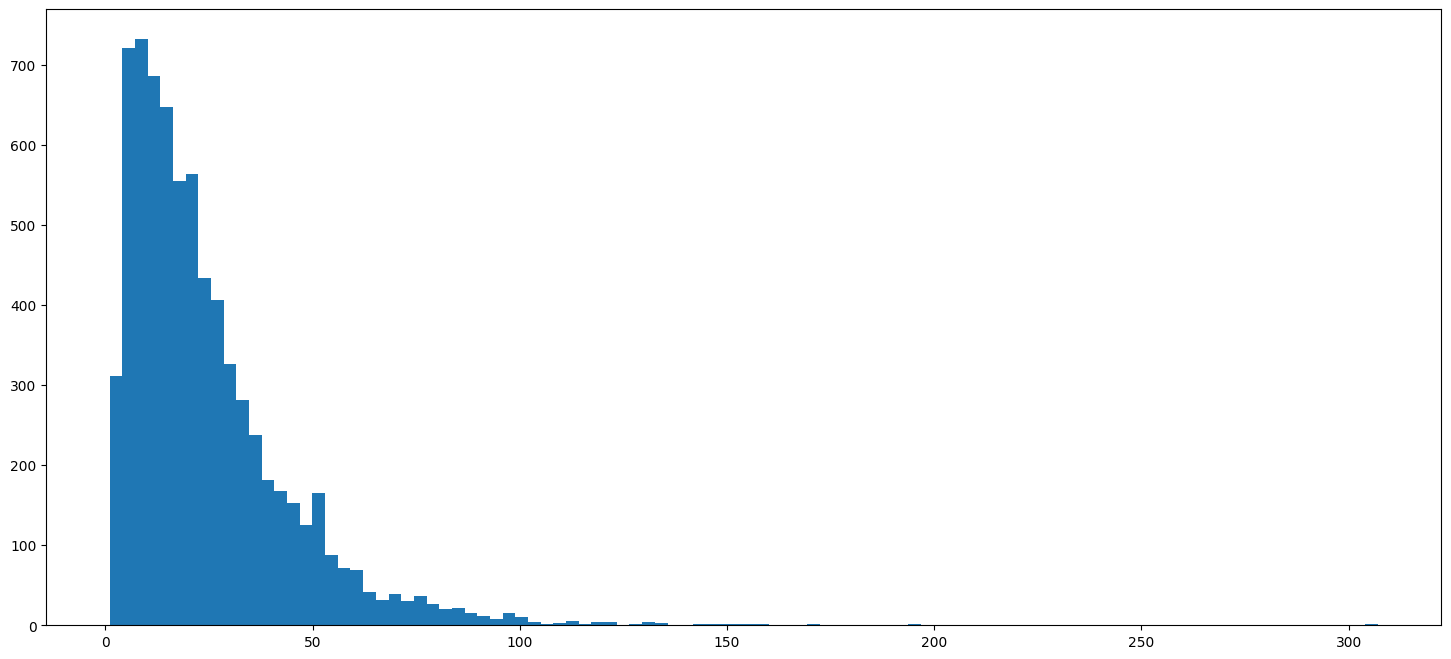

In [11]:
plt.figure(figsize=(18, 8))
plt.hist([len(s) for s in sentences], bins=100)
plt.show()

In [12]:
%%time
tokenizer = AutoTokenizer.from_pretrained(bert_name, do_lower_case = False)

tokenizer_config.json:   0%|          | 0.00/49.0 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/762 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/213k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/436k [00:00<?, ?B/s]

CPU times: user 137 ms, sys: 14.9 ms, total: 152 ms
Wall time: 1.36 s


In [13]:
def tokenize_and_preserve_labels(sentence, text_labels):
    tokenized_sentence = []
    labels = []

    for word, label in zip(sentence, text_labels):

        # Tokenize the word and count # of subwords the word is broken into
        tokenized_word = tokenizer.tokenize(word)
        n_subwords = len(tokenized_word)

        # Add the tokenized word to the final tokenized word list
        tokenized_sentence.extend(tokenized_word)

        # Add the same label to the new list of labels `n_subwords` times
        labels.extend([label] * n_subwords)

    return tokenized_sentence, labels

In [14]:
def split_sentence_with_overlap(s_words, s_labels, tokenizer,
                                max_len=MAX_LEN, overlap=OVERLAP):
    """
    Разделить предложение на части с перекрытием.
    :param s_words: предложение -> список слов для разделения
    :param s_labels: список меток слов
    :param tokenizer: экземпляр токенизатора
    :param max_len: максимальная длина части
    :param overlap: процент перекрытия
    :return: список частей предложения и список частей меток
    """
    chunk_size = max_len - 12  # Оставляем место для специальных токенов
    overlap_size = int(chunk_size * overlap)
    chunks = []
    start_index = end_index = 0
    while end_index < len(s_words):
        end_index = start_index + chunk_size
        chunk_words = s_words[start_index:end_index]
        chunk_text = ' '.join(chunk_words)

        # Токенизируем текст, чтобы убедиться в том, что длина в токенах не превышает max_len
        tokens = tokenizer.tokenize(chunk_text)
        while len(tokens) > chunk_size and len(chunk_words):
            chunk_words = chunk_words[:-1]
            chunk_text = ' '.join(chunk_words)
            tokens = tokenizer.tokenize(chunk_text)

        chunks.append((chunk_words,
                       s_labels[start_index: start_index + len(chunk_words)],
                       start_index))

        # У нас один чанк и нечего дальше крутить цикл - виснет
        if len(chunk_words) == len(s_words):
            break

        # найдем сколько слов входит в перекрытие для вычисления индекса смещения
        tokens = []
        overlap_index = 0
        reversed_words = chunk_words[::-1]
        # пока длина токенов перекрытия меньше размера перекрытия добавляем по одному слову
        while len(tokens) < overlap_size:
            overlap_index += 1
            tokens = tokenizer.tokenize(' '.join(reversed_words[:overlap_index]))

        end_index = start_index + len(chunk_words)
        # Следующая часть начинается с учетом перекрытия
        start_index += len(chunk_words) - overlap_index

    new_words, new_labels = [], []
    for chunk_words, chunk_labels, start_index in chunks:
        new_words.append(chunk_words)
        new_labels.append(chunk_labels)

    return new_words, new_labels


def split_sentences(sentences, labels, row_labels, tokenizer, max_len=MAX_LEN, overlap=OVERLAP):
    """
    Обработка списка списков предложений и списка списков меток
    :param sentences: список списков предложений
    :param labels: список списков меток
    :param row_labels: список меток предложений (нужно для стратификации)
    :param tokenizer: экземпляр токенизатора
    :param max_len: максимальная длина части
    :param overlap: процент перекрытия
    :return: новые списки предложений и меток
    """
    new_sentences, new_labels, new_row_labels, idx_rows = [], [], [], []

    print('Разделение предложений на части:')
    for idx, (s_words, s_labels, s_row) in tqdm(enumerate(zip(sentences, labels, row_labels)),
                                                total=len(sentences)):
        spl_snt, spl_lbl = split_sentence_with_overlap(s_words,
                                                       s_labels,
                                                       tokenizer,
                                                       max_len=max_len,
                                                       overlap=overlap)
        new_sentences.extend(spl_snt)
        new_labels.extend(spl_lbl)
        new_row_labels.extend([s_row] * len(spl_snt))
        idx_rows.extend([idx] * len(spl_snt))

    return new_sentences, new_labels, new_row_labels, idx_rows

In [15]:
# разделение длинных предложений на части, так чтобы одно предложение не выходило за предел MAX_LEN токенов

print(f'Количество предложений до: {len(sentences)}\n')

sentences, labels, row_labels, idx_rows = split_sentences(sentences, labels, row_labels,
                                                          tokenizer, overlap=0.25)

print(f'\nКоличество предложений после: {len(sentences)}')

Количество предложений до: 7274

Разделение предложений на части:


100%|██████████| 7274/7274 [00:01<00:00, 6736.04it/s]


Количество предложений после: 7274


In [16]:
tokenized_texts_and_labels = [
    tokenize_and_preserve_labels(sent, labs)
    for sent, labs in zip(sentences, labels)
]

In [17]:
tokenized_texts = [token_label_pair[0] for token_label_pair in tokenized_texts_and_labels]

labels = [token_label_pair[1] for token_label_pair in tokenized_texts_and_labels]

input_ids = pad_sequences([tokenizer.convert_tokens_to_ids(txt) for txt in tokenized_texts],
                          maxlen = MAX_LEN, dtype = "long", value = 0.0,
                          truncating = "post", padding = "post")

tags = pad_sequences([[tag2idx.get(l) for l in lab] for lab in labels],
                     maxlen = MAX_LEN, value = tag2idx["PAD"], padding = "post",
                     dtype = "long", truncating = "post")

attention_masks = [[float(i != 0.0) for i in ii] for ii in input_ids]

In [18]:
tokenized_texts[0]

['Book',
 'I',
 'I',
 'On',
 'a',
 'January',
 'evening',
 'of',
 'the',
 'early',
 'seven',
 '##ties',
 ',',
 'Christine',
 'Ni',
 '##lsson',
 'was',
 'singing',
 'in',
 'Faust',
 'at',
 'the',
 'Academy',
 'of',
 'Music',
 'in',
 'New',
 'York',
 '.']

In [19]:
labels[0]

['O',
 'O',
 'O',
 'O',
 'O',
 'O',
 'O',
 'O',
 'O',
 'O',
 'O',
 'O',
 'O',
 'B-PER',
 'I-PER',
 'I-PER',
 'O',
 'O',
 'O',
 'O',
 'O',
 'O',
 'O',
 'O',
 'O',
 'O',
 'B-LOC',
 'I-LOC',
 'O']

In [22]:
def get_model():
    
    model = AutoModelForTokenClassification.from_pretrained(
        bert_name,
        num_labels = len(tag2idx),
        output_attentions = False,
        output_hidden_states = False,
        ignore_mismatched_sizes=True,
    )
    
    model.to(device)
    
    FULL_FINETUNING = True
    if FULL_FINETUNING:
        param_optimizer = list(model.named_parameters())
        no_decay = ['bias', 'gamma', 'beta']
        optimizer_grouped_parameters = [
            {'params': [p for n, p in param_optimizer if not any(nd in n for nd in no_decay)],
             'weight_decay_rate': 0.01},
            {'params': [p for n, p in param_optimizer if any(nd in n for nd in no_decay)],
             'weight_decay_rate': 0.0}
        ]
    else:
        param_optimizer = list(model.classifier.named_parameters())
        optimizer_grouped_parameters = [{"params": [p for n, p in param_optimizer]}]

    optimizer = AdamW(
        optimizer_grouped_parameters,
        lr=3e-5,
        eps=1e-8
    )    
    
    return model, optimizer

In [23]:
def train_model(name_model, best_score_total=0):
    
    epochs = 30
    max_grad_norm = 1.0

    # Total number of training steps is number of batches * number of epochs.
    total_steps = len(train_dataloader) * epochs

    # Create the learning rate scheduler.
    scheduler = get_linear_schedule_with_warmup(
        optimizer,
        num_warmup_steps = 0,
        num_training_steps = total_steps
    )
    ## Store the average loss after each epoch so we can plot them.
    loss_values, validation_loss_values = [], []
    best_score = 0
    not_increase = 0
    not_increase_stop = 3

    #for _ in trange(epochs, desc = "Epoch"):
    for epoch in range(epochs):
        # ========================================
        #               Training
        # ========================================
        # Perform one full pass over the training set.

        # Put the model into training mode.
        model.train()
        # Reset the total loss for this epoch.
        total_loss = 0

        # Training loop
        for step, batch in tqdm(enumerate(train_dataloader), total=len(train_dataloader)):
            # Перенос батча на GPU
            batch = tuple(t.to(device) for t in batch)
            b_input_ids, b_input_mask, b_labels = batch

            # Убедитесь, что метки имеют тип LongTensor
            b_labels = b_labels.long()

            # Всегда очищайте любые ранее рассчитанные градиенты перед выполнением обратного прохода
            model.zero_grad()

            # Прямой проход
            outputs = model(
                b_input_ids, 
                token_type_ids=None,
                attention_mask=b_input_mask, 
                labels=b_labels
            )

            # Получение потерь
            loss = outputs[0]
            # Выполнение обратного прохода для расчета градиентов
            loss.backward()
            # Отслеживание тренировочных потерь
            total_loss += loss.item()
            # Ограничение нормы градиента
            torch.nn.utils.clip_grad_norm_(parameters=model.parameters(), max_norm=max_grad_norm)
            # Обновление параметров
            optimizer.step()
            # Обновление скорости обучения
            scheduler.step()
            

        # Calculate the average loss over the training data.
        avg_train_loss = total_loss / len(train_dataloader)
        #print("Average train loss: {}".format(avg_train_loss))

        # Store the loss value for plotting the learning curve.
        loss_values.append(avg_train_loss)
    
        # ========================================
        #               Validation
        # ========================================
        # After the completion of each training epoch, measure our performance on
        # our validation set.

        # Put the model into evaluation mode
        model.eval()
        # Reset the validation loss for this epoch.
        eval_loss, eval_accuracy = 0, 0
        nb_eval_steps, nb_eval_examples = 0, 0
        predictions , true_labels = [], []
        for batch in tqdm(valid_dataloader):
            batch = tuple(t.to(device) for t in batch)
            b_input_ids, b_input_mask, b_labels = batch

            # Telling the model not to compute or store gradients,
            # saving memory and speeding up validation
            with torch.no_grad():
                # Forward pass, calculate logit predictions.
                # This will return the logits rather than the loss because we have not provided labels.
                outputs = model(
                    b_input_ids, 
                    token_type_ids = None,
                    attention_mask = b_input_mask, 
                    labels = b_labels
                )
            # Move logits and labels to CPU
            logits = outputs[1].detach().cpu().numpy()
            label_ids = b_labels.to('cpu').numpy()

            # Calculate the accuracy for this batch of test sentences.
            eval_loss += outputs[0].mean().item()
            predictions.extend([list(p) for p in np.argmax(logits, axis = 2)])
            true_labels.extend(label_ids)

        eval_loss = eval_loss / len(valid_dataloader)
        validation_loss_values.append(eval_loss)
    
        #print("Validation loss: {}".format(eval_loss))
        pred_tags = [tag_values[p_i] for p, l in zip(predictions, true_labels)
                                     for p_i, l_i in zip(p, l) if tag_values[l_i] != "PAD"]
        valid_tags = [tag_values[l_i] for l in true_labels
                                      for l_i in l if tag_values[l_i] != "PAD"]
        score_val = f1_score(
                valid_tags, pred_tags, 
                labels = ['O', 'B-PER', 'I-PER', 'B-ORG', 'I-ORG', 'B-LOC', 'I-LOC'], 
                average = 'macro'
        )
        #print("Validation Accuracy: {}".format(accuracy_score(pred_tags, valid_tags)))
        #print("Validation F1-Score: {}".format(score_val))
        if best_score < score_val:
            best_score = score_val         
            not_increase = 0         
            if best_score_total < best_score:
                best_score_total = best_score
                msg = f'save model, {best_score_total}, {score_val}'
                
                # Save the fine-tuned model locally
                model.save_pretrained(f"./models/checkpoint-last")
                
                try:
                    Path(name_model).mkdir(parents = True, exist_ok = True)
                    model.save_pretrained(name_model)
                except:    
                    pass
            else:
                msg = f'... {best_score_total}, {score_val}'
                
            print('epoch:', epoch, msg)
        else:
            not_increase += 1
            msg = f'not_increase = {not_increase}, {best_score}, {score_val}'
            print('epoch:', epoch, msg)
            if not_increase >= not_increase_stop:                
                print('not_increase = ', not_increase_stop)
                break
                
    return best_score_total

In [24]:
SEEDS = 1
scores = []
batch_size = 8

best_score = 0 

folds = 7

train_version = f'base-{folds}F'

for seed in (0, 7, 13, 2024):    
    # kf = KFold(n_splits = 5, random_state = seed, shuffle = True)
    kf = StratifiedKFold(n_splits=folds, random_state=seed, shuffle=True)
    for fold, (train_index, val_index) in enumerate(kf.split(input_ids, row_labels)):
        
#         # оставим наилучший фолд по предыдущим расчетам
#         if fold < 4:
#             continue
        
        test_index = sorted(set([idx_rows[i] for i in val_index]))
        df.iloc[test_index].to_csv(f'seed_{seed}_{train_version}_fold_{fold}.csv', index=False)
        
        clear_output(wait = False)
        print('SEED', seed, 'Fold', fold)
        print(np.mean(scores) - np.std(scores))
        
        tr_inputs  = input_ids[train_index]
        val_inputs = input_ids[val_index]
        
        tr_tags  = tags[train_index]
        val_tags = tags[val_index]
        
        tr_masks  = np.array(attention_masks)[train_index]
        val_masks = np.array(attention_masks)[val_index]
        
        tr_inputs = torch.tensor(tr_inputs)
        val_inputs = torch.tensor(val_inputs)

        tr_tags = torch.tensor(tr_tags, dtype=torch.long)
        val_tags = torch.tensor(val_tags, dtype=torch.long)

        tr_masks = torch.tensor(tr_masks)
        val_masks = torch.tensor(val_masks)
        
        train_data = TensorDataset(tr_inputs, tr_masks, tr_tags)
        train_sampler = RandomSampler(train_data)
        train_dataloader = DataLoader(train_data, sampler = train_sampler, batch_size = batch_size)
        
        valid_data = TensorDataset(val_inputs, val_masks, val_tags)
        valid_sampler = SequentialSampler(valid_data)
        valid_dataloader = DataLoader(valid_data, sampler = valid_sampler, batch_size = batch_size)
        
        model, optimizer = get_model()
        
        name_model = f'./best_model-{fold}-{folds}'
        score = train_model(name_model, best_score)
        scores.append(score)   
        best_score = score
               
        del model, optimizer; gc.collect()     
        
        # хватит одного фолда
#         break
        
print(np.mean(scores) - np.std(scores))

SEED 0 Fold 6
0.7930545469072661


Some weights of BertForTokenClassification were not initialized from the model checkpoint at bert-large-cased and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
100%|██████████| 130/130 [00:55<00:00,  2.32it/s]


epoch: 0 ... 0.7930545469072661, 0.49684107054952664


100%|██████████| 130/130 [00:56<00:00,  2.32it/s]


epoch: 1 ... 0.7930545469072661, 0.7227178060744043


100%|██████████| 130/130 [00:55<00:00,  2.32it/s]


epoch: 2 ... 0.7930545469072661, 0.7507606829250302


100%|██████████| 130/130 [00:55<00:00,  2.32it/s]


epoch: 3 not_increase = 1, 0.7507606829250302, 0.7239057475605387


100%|██████████| 130/130 [00:56<00:00,  2.32it/s]


epoch: 4 not_increase = 2, 0.7507606829250302, 0.7288767275187809


100%|██████████| 130/130 [00:56<00:00,  2.32it/s]


epoch: 5 ... 0.7930545469072661, 0.7810240555960257


100%|██████████| 130/130 [00:55<00:00,  2.33it/s]


epoch: 6 not_increase = 1, 0.7810240555960257, 0.7546918067046658


100%|██████████| 130/130 [00:56<00:00,  2.32it/s]


epoch: 7 ... 0.7930545469072661, 0.7813427535266051


100%|██████████| 130/130 [00:55<00:00,  2.32it/s]


epoch: 8 not_increase = 1, 0.7813427535266051, 0.7111319855720871


100%|██████████| 130/130 [00:56<00:00,  2.32it/s]


epoch: 9 not_increase = 2, 0.7813427535266051, 0.7685407247696473


100%|██████████| 130/130 [00:56<00:00,  2.32it/s]


epoch: 10 not_increase = 3, 0.7813427535266051, 0.7295881763485099
not_increase =  3
0.7930545469072661


In [25]:
from IPython.display import display, FileLink
from zipfile import ZipFile, ZIP_DEFLATED as ZD
from glob import glob

_name = bert_name.split('/')[0]

files = glob(f'models/checkpoint-last/*.*') + glob('*.csv')
zip_filename = f'model_{_name}_{train_version}.zip'
with ZipFile(zip_filename, 'w',  compression=ZD, compresslevel=9) as zip_file:
    for filename in files:
        print(filename)
        zip_file.write(filename)
FileLink(zip_filename)

models/checkpoint-last/config.json
models/checkpoint-last/model.safetensors
seed_0_base-7F_fold_4.csv
seed_0_base-7F_fold_5.csv
seed_0_base-7F_fold_6.csv


/kaggle/working/model_bert-large-cased_base-7F.zip